In [120]:
#disable warnings
import warnings
warnings.filterwarnings("ignore") 

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
#stuff

# Purpose of this Notebook

In [51]:
#Number of reviews to put into data frame of good reviews. Set it to less than 0 if you want all of the good reviews to be processed
NUMB_OF_GOOD_REVIEWS = -1

#Number of reviews to put into data frame of bad reviews
NUMB_OF_BAD_REVIEWS = -1

#set to 1 if you want to reclean the dataframes, otherwise it will load data from a previous clean
#note cleaning takes 30 minutes on a pretty fast machine
CLEAN_DATAFRAME = 0

## Problem Statement

Product developers often want to know this about their products:

* For products that people don't like, what is it about the products they don't like? Maybe if we know this we could improve the product by fixing this unliked product features
* For products that people love, what is it about the products that result in people loving them? Maybe if we expanded on these loved features, we could get new customers or better retain current customers

## Proposed Solution

Topic modeling and clustering(?) that identifies the features of products that people love and somehow rank them so that a product manaer can have a priority list of things that could be addressed to get more love
Topic modeling and clustering(?) that identifies the features of products that people don't like and somehow rank them so that a product manaer can have a priority list of things that could be fixed to hopefully turn the disliked product into a liked product.


# Module Import

In [173]:
import datetime
from collections import Counter
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

#to speed up pandas operands
from pandarallel import pandarallel

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA

import nltk
from nltk.corpus import wordnet
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer



#gensim
from gensim import corpora, models, similarities, matutils



In [332]:
# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'png'
%matplotlib inline 

# NLP Pipeline



## Text Preprocessing
Essentially will do this:

```

(input text) -->[clean(remove text I don't want)]--> [tokenization] --> [lemmatization] --> [Next_Stages]

```

In [29]:
reviews_df = pd.read_csv("../Data/Reviews.csv")

In [30]:
reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [31]:
reviews_df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [32]:
reviews_df.loc[0,"Text"]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [33]:
reviews_df["Score"].value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

According to the Kaggle description `HelpfulnessNumerator` should be less than or equal to `HelpfulnessDenominator`. So I will filter out any reviews that do not meet this specification.  Also, removing reviews where `HelpfulnessDenominator` is zero as this indicates a review that is not useful:

In [34]:
mask = (reviews_df["HelpfulnessNumerator"] <=  reviews_df["HelpfulnessDenominator"]) & (reviews_df["HelpfulnessDenominator"]!=0)
reviews_df[~mask].shape

(270054, 10)

There are few to remove so doing that now:

In [35]:
reviews_df = reviews_df[mask]

Are there any duplicate entries?

In [36]:
reviews_df.duplicated(subset=["UserId","ProfileName","Time","Text"],keep="first").value_counts()

False    209681
True      88719
dtype: int64

In [37]:
reviews_df.drop_duplicates(subset=["UserId","ProfileName","Time","Text"],keep="first",inplace=True)

In [38]:
reviews_df.dropna(inplace=True)

calculating a helpfulness metric in the hopes that it helps separate reviews.

In [39]:
reviews_df["helpful_rating"] = reviews_df["HelpfulnessNumerator"] / reviews_df["HelpfulnessDenominator"]

In [40]:
# Not helpful
# TODO: Delete
#plt.figure(figsize=(40,40))
#plt.scatter(reviews_df["Score"],reviews_df["helpful_rating"],alpha=0.5)
#plt.xlabel("Score")
#plt.ylabel("helpful rating")
#plt.show();

Going to create a dataframe of bad reviews and one of good reviews to process separately. I remove reviews where "Score" == 3 because do not indicate a call to action to either improve a bad product or point out a product that likely has nice features.

In [41]:
reviews_df.shape

(209675, 11)

In [42]:
good_reviews_df = reviews_df[ reviews_df["Score"] >= 4 ]
bad_reviews_df = reviews_df[ reviews_df["Score"] <= 2 ]

In [43]:
if (NUMB_OF_GOOD_REVIEWS > good_reviews_df.shape[0]) or (NUMB_OF_GOOD_REVIEWS < 0):
    NUMB_OF_GOOD_REVIEWS = good_reviews_df.shape[0]


if (NUMB_OF_BAD_REVIEWS > bad_reviews_df.shape[0]) or (NUMB_OF_BAD_REVIEWS < 0):
    NUMB_OF_BAD_REVIEWS = bad_reviews_df.shape[0]

In [44]:
good_reviews_df = good_reviews_df[:(NUMB_OF_GOOD_REVIEWS + 1)]
bad_reviews_df = bad_reviews_df[:(NUMB_OF_BAD_REVIEWS + 1)]

In [45]:
#stuff = list(good_reviews_df.Text.head(NUMB_OF_DOCS1))

Thoughts on mispelled words and non English words:

What I'm trying to do here (TODO describe this) is identify adjectives. So I will remove words that are not in nltk's corpus of words to hopefully remove misspelled words and non-English words.

In [46]:
#Removing HTML from the text
#stuff = [re.sub("<.*?>","",item) for item in stuff]

def remove_html_punct(row):
    """This function removes HTML and punctuation and anything that is or contains a number from the Text"""
    
    NLTK_WORDS = set(nltk.corpus.words.words())
    
    text_to_process = row["Text"]
    text_to_process = text_to_process.lower()
    text_to_process = re.sub("<.*?>","",text_to_process)
    text_to_process = re.sub("[\.|\!|\?|\,|\;|\:|\&|\(|\)|\-|\%|_]","",text_to_process)
    text_to_process = re.sub("\w*\d+\w*","",text_to_process)
    text_to_process_list = text_to_process.split()
    text_to_process_list = [review_word for review_word in text_to_process_list if review_word in NLTK_WORDS]
    text_to_process = " ".join(text_to_process_list)
    return text_to_process



In [47]:
if CLEAN_DATAFRAME == 1:

    #TODO If you have time - convert it to a SQL query
    pandarallel.initialize()

    start_time = datetime.datetime.now()

    good_reviews_df["ProcessedText"] = good_reviews_df.parallel_apply(remove_html_punct,axis=1)
    bad_reviews_df["ProcessedText"] = bad_reviews_df.parallel_apply(remove_html_punct,axis=1)
    end_time = datetime.datetime.now()
    print("time spent doing operation is {}".format(end_time - start_time))
else:
    print("skipping cleaning the data frame.")

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:39:20.648521


In [48]:
good_reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpful_rating,ProcessedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,i have bought several of the vitality canned d...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,this is a confection that been around a few it...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,1.0,right now mostly just sprouting this so my can...
10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,1.0,i know if the or the tequila or just the uniqu...
11,12,B0009XLVG0,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",4,4,5,1282867200,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...,1.0,one of my to lose some weight and the other i ...


In [49]:
bad_reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpful_rating,ProcessedText
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,if you are looking for the secret ingredient i...
12,13,B0009XLVG0,A327PCT23YH90,LT,1,1,1,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,1.0,my have been happily eating platinum for more ...
26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,1,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",0.0,the candy is just red no flavor just plan and ...
50,51,B001EO5QW8,A108P30XVUFKXY,Roberto A,0,7,1,1203379200,Don't like it,"This oatmeal is not good. Its mushy, soft, I d...",0.0,this oatmeal is not good its mushy soft i like...
62,63,B001EO5TPM,A1E09XGZUR78C6,gary sturrock,2,2,1,1215302400,stale product.,Arrived in 6 days and were so stale i could no...,1.0,in days and were so stale i could not eat any ...


It takes a long time to perform this operation so going to save it to a pickle file if I ever need to rerun but don't need to do this cleaning step.

In [65]:
if CLEAN_DATAFRAME == 1:
    
    GOOD_REVIEWS_FILE = open("../Data/good_reviews.pkl","wb")
    BAD_REVIEWS_FILE = open("../Data/bad_reviews.pkl","wb")
    pickle.dump(good_reviews_df, GOOD_REVIEWS_FILE)
    pickle.dump(bad_reviews_df, BAD_REVIEWS_FILE)
    BAD_REVIEWS_FILE.close()
    GOOD_REVIEWS_FILE.close()
    
else:
    
    GOOD_REVIEWS_FILE = open("../Data/good_reviews.pkl","rb")
    BAD_REVIEWS_FILE = open("../Data/bad_reviews.pkl","rb")
    good_reviews_df = pickle.load(GOOD_REVIEWS_FILE)
    bad_reviews_df = pickle.load(BAD_REVIEWS_FILE)
    

In [66]:
good_reviews_df.reset_index(inplace=True)

In [67]:
good_reviews_df.loc[0,"Text"]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [68]:
good_reviews_df.loc[0,"ProcessedText"]

'i have bought several of the vitality canned dog food and have found them all to be of good quality the product more like a stew than a meat and it better my is and she this product better than most'

In [69]:
bad_reviews_df.reset_index(inplace=True)

In [70]:
bad_reviews_df.loc[0,"Text"]

'If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The flavor is very medicinal.'

In [71]:
bad_reviews_df.loc[0,"ProcessedText"]

'if you are looking for the secret ingredient in i believe i have found it i got this in addition to the root beer extract i ordered which was good and made some cherry soda the flavor is very medicinal'

**Tokenize**

In [72]:
#stuff_tokenized= []
#stuff_tokenized = [word_tokenize(review) for review in stuff]

def tokenize_text(row):
    temp_tokenized_txt = word_tokenize(row["ProcessedText"])
    return temp_tokenized_txt


In [73]:
pandarallel.initialize()
start_time = datetime.datetime.now()
good_reviews_df["ProcessedText"] = good_reviews_df.parallel_apply(tokenize_text,axis=1)
bad_reviews_df["ProcessedText"] = bad_reviews_df.parallel_apply(tokenize_text,axis=1)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:11.049250


In [74]:
good_reviews_df.loc[0,"ProcessedText"]

['i',
 'have',
 'bought',
 'several',
 'of',
 'the',
 'vitality',
 'canned',
 'dog',
 'food',
 'and',
 'have',
 'found',
 'them',
 'all',
 'to',
 'be',
 'of',
 'good',
 'quality',
 'the',
 'product',
 'more',
 'like',
 'a',
 'stew',
 'than',
 'a',
 'meat',
 'and',
 'it',
 'better',
 'my',
 'is',
 'and',
 'she',
 'this',
 'product',
 'better',
 'than',
 'most']

In [75]:
bad_reviews_df.loc[0,"ProcessedText"]

['if',
 'you',
 'are',
 'looking',
 'for',
 'the',
 'secret',
 'ingredient',
 'in',
 'i',
 'believe',
 'i',
 'have',
 'found',
 'it',
 'i',
 'got',
 'this',
 'in',
 'addition',
 'to',
 'the',
 'root',
 'beer',
 'extract',
 'i',
 'ordered',
 'which',
 'was',
 'good',
 'and',
 'made',
 'some',
 'cherry',
 'soda',
 'the',
 'flavor',
 'is',
 'very',
 'medicinal']

In [76]:
#for i,item in enumerate(stuff_tokenized):
#    if i == 10:
#        break
#    print(i,"-->",item,"\n")

In [77]:
wordNetLemmatizer = WordNetLemmatizer()

In [78]:
#lemmatize each word in stuff
def calc_partofspeech(raw_pos):
    """translates from POS generated by pos_tag() to a POS encoding that WordNetLemmatizer.lemmatize() understands"""
    #print("word = ",word)
    #[(output_word, output_pos)] = pos_tag(word_tokenize(word))
    
    #decode output_pos to the pos required by the lemmatizer
    
    if "JJ" in raw_pos:
        pos = "a"
    elif "RB" in raw_pos:
        pos = "r"
    elif "VB" in raw_pos:
        pos = "v"
    else:
        pos = "n"
    
    return pos




In [79]:
#for i,item in enumerate(stuff):
#   if i == 10:
#        break
#   print(i,"-->",item,"\n")

In [80]:
#stuff_tokenized[0]

In [81]:
def lemmatize_it(row):
    
    pos_result = pos_tag(row["ProcessedText"])
    
    temp_mydoc_lemmatized = []
    
    for myword,myPOS in pos_result:
        temp_word_lemmatized = wordNetLemmatizer.lemmatize(myword,calc_partofspeech(myPOS))
        temp_mydoc_lemmatized.append(temp_word_lemmatized)
    
    return temp_mydoc_lemmatized
        


In [82]:
pandarallel.initialize()
start_time = datetime.datetime.now()
good_reviews_df["ProcessedText"] = good_reviews_df.parallel_apply(lemmatize_it,axis=1)
bad_reviews_df["ProcessedText"] = bad_reviews_df.parallel_apply(lemmatize_it,axis=1)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:01:05.685067


lemmatizing to cut down on the size of the dimensions of the eventual vectorized word matrix without losing meaning of the text

In [83]:
good_reviews_df.loc[0,"ProcessedText"] 

['i',
 'have',
 'buy',
 'several',
 'of',
 'the',
 'vitality',
 'can',
 'dog',
 'food',
 'and',
 'have',
 'find',
 'them',
 'all',
 'to',
 'be',
 'of',
 'good',
 'quality',
 'the',
 'product',
 'more',
 'like',
 'a',
 'stew',
 'than',
 'a',
 'meat',
 'and',
 'it',
 'good',
 'my',
 'be',
 'and',
 'she',
 'this',
 'product',
 'good',
 'than',
 'most']

In [84]:
bad_reviews_df.loc[0,"ProcessedText"] 

['if',
 'you',
 'be',
 'look',
 'for',
 'the',
 'secret',
 'ingredient',
 'in',
 'i',
 'believe',
 'i',
 'have',
 'find',
 'it',
 'i',
 'get',
 'this',
 'in',
 'addition',
 'to',
 'the',
 'root',
 'beer',
 'extract',
 'i',
 'order',
 'which',
 'be',
 'good',
 'and',
 'make',
 'some',
 'cherry',
 'soda',
 'the',
 'flavor',
 'be',
 'very',
 'medicinal']

In [ ]:
#Test code doesn't need to be run
#myword = "running"
#myword_lemmed = wordNetLemmatizer.lemmatize(myword,calc_partofspeech(myword))
#myword_lemmed = wordNetLemmatizer.lemmatize(myword,"v")

#print("myword_lemmed = ",myword_lemmed)
#print("POS for myword = ",calc_partofspeech(myword))

In [ ]:
#stuff_lemmatized[0]

In [ ]:
# I only want adjectives and adverbs sent to the vectorizer
#stuff_pos_filtered = [mylemword for mylemdoc in stuff_lemmatized for mylemword in mylemdoc if ("JJ" in pos_tag(word_tokenize(mylemword))[0][1]) or ("RB" in pos_tag(word_tokenize(mylemword))[0][1])]

In [ ]:
#stuff_pos_filtered[6]

In [ ]:
# I only want adjectives and adverbs sent to the vectorizer

def filter_pos(row,pos_abbrev=["JJ"]):
    """
    takes as input the following
    processes the "ProcessedText" column of a review data frame (see definition above)
    pos_abbrev = list of NLTK pos_tag() output parts of speech codes abbreviated to the first two characters
    
    """
#    print("pos_abbrev = ",pos_abbrev)

    
    if type(pos_abbrev) != type([]):
        print("post_abbrev must be a list of POS codes (1st 2 characters of the code only)")
        return 1
    
    temp_pos_filtered_doc = ""
    
    #pos_tag() works better if you pass the entire document to it as a tokenized list
    #it must be doing some sequence modeling under the hood to get the context of words so that it can
    #better ID parts of speech
        
    pos_result = pos_tag(row["ProcessedText"])
    
    for result_word, result_pos in pos_result:
        #print("tokenized word = ", word_tokenize(mylemword))
        #print("tokenized word pos = ", pos_tag(word_tokenize(mylemword))[0][1])
        
        for mypos in pos_abbrev:
            if (mypos in result_pos) :
                temp_pos_filtered_doc = temp_pos_filtered_doc + result_word + " "
            
    
    return temp_pos_filtered_doc.rstrip()


This cell edits each review removing all words except adjectives and adverbs

Thoughts on removing adjectives: (TODO expand on it). Turns out just focusing on the adjectives makes the topics generated by LDA _less_ interpretable. So will be including the entire review in the LDA analysis. So now just running `join()` on the tokenized reviews.

In [85]:
#stuff_pos_filtered = filter_pos(stuff_lemmatized,pos_abbrev=["JJ","RB"])
#stuff_pos_filtered
#stuff_pos_filtered = stuff_pos_filtered + filter_pos(stuff_lemmatized,"RB")

#Not doing this to see how LDA works when it's given all of the words of  each reive.
#pandarallel.initialize()
#start_time = datetime.datetime.now()
#good_reviews_df["ProcessedText"] = good_reviews_df.parallel_apply(filter_pos,axis=1,pos_abbrev=["JJ","RB"])
#end_time = datetime.datetime.now()
#print("time spent doing operation is {}".format(end_time - start_time))

pandarallel.initialize()
start_time = datetime.datetime.now()
good_reviews_df["ProcessedText"] = good_reviews_df.parallel_apply(lambda x : " ".join(x["ProcessedText"]),axis=1)
bad_reviews_df["ProcessedText"] = bad_reviews_df.parallel_apply(lambda x : " ".join(x["ProcessedText"]),axis=1)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))



INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:19.741844


In [86]:
good_reviews_df.loc[0,"ProcessedText"]

'i have buy several of the vitality can dog food and have find them all to be of good quality the product more like a stew than a meat and it good my be and she this product good than most'

In [87]:
bad_reviews_df.loc[0,"ProcessedText"]

'if you be look for the secret ingredient in i believe i have find it i get this in addition to the root beer extract i order which be good and make some cherry soda the flavor be very medicinal'

In [ ]:
#stuff_lemmatized[0]

In [ ]:
#stuff_nouns = filter_pos(stuff_lemmatized,pos_abbrev=["NN"])

In [ ]:
#stuff_nouns[0:3]

In [ ]:
#stuff_pos_filtered[0:5]

In [ ]:
#len(stuff_pos_filtered)

Final shape of bad and good reviews dataframes

In [89]:
good_reviews_df.shape

(152586, 13)

In [88]:
bad_reviews_df.shape

(40420, 13)

(TODO Think through the math and come up with a way to include the "3" reviews into the analysis in a way that improves the results or bottom out to a good mathematical rationale on why excluding them is the best approach)

## Word Vectorization / Parsing

Will do the following here:

```

(lemmatized text)-->[WordVectorization(dropping stop word)] --> [POS tagging] --> [collect Adjectives]


```


In [126]:
vectorizer_gr = CountVectorizer(stop_words="english")
docTermMatrixCountVecGR = vectorizer_gr.fit_transform(good_reviews_df["ProcessedText"])

tfidfvectorizer_gr = TfidfVectorizer(stop_words='english')
docTermMatrixTFIDFGR = tfidfvectorizer_gr.fit_transform(good_reviews_df["ProcessedText"])


In [127]:
vectorizer_br = CountVectorizer(stop_words="english")
docTermMatrixCountVecBR = vectorizer_br.fit_transform(bad_reviews_df["ProcessedText"])

tfidfvectorizer_br = TfidfVectorizer(stop_words='english')
docTermMatrixTFIDFBR = tfidfvectorizer_br.fit_transform(bad_reviews_df["ProcessedText"])

In [92]:
len(vectorizer_gr.get_feature_names())

21926

In [123]:
docTermMatrixTFIDFBR.shape

(40420, 15183)

In [128]:
docTermMatrixTFIDFGR.shape

(152586, 21926)

In [93]:
len(vectorizer_br.get_feature_names())

15183

In [94]:
docTermMatrixCountVecGR.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [95]:
docTermMatrixCountVecGR.shape

(152586, 21926)

In [96]:
docTermMatrixCountVecBR.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [97]:
docTermMatrixCountVecBR.shape

(40420, 15183)

In [131]:
docTermMatrixTFIDFGR_df = pd.DataFrame(
    docTermMatrixTFIDFGR.toarray(),
    index=good_reviews_df["ProcessedText"],
    columns=tfidfvectorizer_gr.get_feature_names()
)

In [132]:
docTermMatrixTFIDFGR_df.head(3)

,aa,aardvark,aback,abandon,abandoned,abb,abbey,abbot,abbreviation,abdomen,...,zodiac,zombie,zone,zoo,zoom,zooplankton,zoster,zowie,zucchini,zwieback
ProcessedText,,,,,,,,,,,,,,,,,,,,,
i have buy several of the vitality can dog food and have find them all to be of good quality the product more like a stew than a meat and it good my be and she this product good than most,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
this be a confection that be around a few it be a light pillowy citrus gelatin with in this case and it be cut into tiny and then liberally coat with powdered sugar and it be a tiny mouthful of heaven not too chewy and very flavorful i highly recommend this yummy treat if you be familiar with the story of lion the witch and the this be the treat that into sell out his brother and to the witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
right now mostly just sprout this so my can eat the grass they love it i rotate it around with and rye too,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:

docTermMatrixCountVecGR_df = pd.DataFrame(docTermMatrixCountVecGR.toarray(), index=good_reviews_df["ProcessedText"], columns=vectorizer_gr.get_feature_names())

In [101]:
docTermMatrixCountVecGR_df.head(2)

,aa,aardvark,aback,abandon,abandoned,abb,abbey,abbot,abbreviation,abdomen,...,zodiac,zombie,zone,zoo,zoom,zooplankton,zoster,zowie,zucchini,zwieback
ProcessedText,,,,,,,,,,,,,,,,,,,,,
i have buy several of the vitality can dog food and have find them all to be of good quality the product more like a stew than a meat and it good my be and she this product good than most,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
this be a confection that be around a few it be a light pillowy citrus gelatin with in this case and it be cut into tiny and then liberally coat with powdered sugar and it be a tiny mouthful of heaven not too chewy and very flavorful i highly recommend this yummy treat if you be familiar with the story of lion the witch and the this be the treat that into sell out his brother and to the witch,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
docTermMatrixCountVecBR_df = pd.DataFrame(docTermMatrixCountVecBR.toarray(), index=bad_reviews_df["ProcessedText"], columns=vectorizer_br.get_feature_names())

In [104]:
docTermMatrixCountVecBR_df.head(2)

,aa,aback,abalone,abandon,abandoned,abandonment,abbey,abdomen,abdominal,aberrant,...,zipper,zippy,zombie,zone,zoo,zoology,zoom,zoonotic,zucchini,zwieback
ProcessedText,,,,,,,,,,,,,,,,,,,,,
if you be look for the secret ingredient in i believe i have find it i get this in addition to the root beer extract i order which be good and make some cherry soda the flavor be very medicinal,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
my have be happily eat platinum for more than two i just get a new bag and the shape of the food be different they try the new food when i first put it in their bowl and now the bowl sit full and the will not touch the food similar relate to formula in the past unfortunately i now need to find a new food that my will eat,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
docTermMatrixTFIDFBR_df = pd.DataFrame(
    docTermMatrixTFIDFBR.toarray(),
    index=bad_reviews_df["ProcessedText"],
    columns=tfidfvectorizer_br.get_feature_names()
)

In [135]:
docTermMatrixTFIDFBR_df.head(3)

,aa,aback,abalone,abandon,abandoned,abandonment,abbey,abdomen,abdominal,aberrant,...,zipper,zippy,zombie,zone,zoo,zoology,zoom,zoonotic,zucchini,zwieback
ProcessedText,,,,,,,,,,,,,,,,,,,,,
if you be look for the secret ingredient in i believe i have find it i get this in addition to the root beer extract i order which be good and make some cherry soda the flavor be very medicinal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
my have be happily eat platinum for more than two i just get a new bag and the shape of the food be different they try the new food when i first put it in their bowl and now the bowl sit full and the will not touch the food similar relate to formula in the past unfortunately i now need to find a new food that my will eat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
the candy be just red no flavor just plan and chewy i would never buy them again,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
docTermMatrixCountVecGR_df.columns

Index(['aa', 'aardvark', 'aback', 'abandon', 'abandoned', 'abb', 'abbey',
       'abbot', 'abbreviation', 'abdomen',
       ...
       'zodiac', 'zombie', 'zone', 'zoo', 'zoom', 'zooplankton', 'zoster',
       'zowie', 'zucchini', 'zwieback'],
      dtype='object', length=21926)

In [106]:
docTermMatrixCountVecBR_df.columns

Index(['aa', 'aback', 'abalone', 'abandon', 'abandoned', 'abandonment',
       'abbey', 'abdomen', 'abdominal', 'aberrant',
       ...
       'zipper', 'zippy', 'zombie', 'zone', 'zoo', 'zoology', 'zoom',
       'zoonotic', 'zucchini', 'zwieback'],
      dtype='object', length=15183)

In [138]:
LD_AllocatorGR = LatentDirichletAllocation(n_components=20, random_state=0,n_jobs=8)
LD_AllocatorBR = LatentDirichletAllocation(n_components=20, random_state=0,n_jobs=8)
LD_AllocatorTFIDFGR = LatentDirichletAllocation(n_components=20, random_state=0,n_jobs=8)
LD_AllocatorTFIDFBR = LatentDirichletAllocation(n_components=20, random_state=0,n_jobs=8)


In [146]:
start_time = datetime.datetime.now()
LD_AllocatorGR.fit(docTermMatrixCountVecGR)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

time spent doing operation is 0:02:40.271267


In [110]:
start_time = datetime.datetime.now()
LD_AllocatorBR.fit(docTermMatrixCountVecBR)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time spent doing operation is 0:00:26.943293


In [139]:
start_time = datetime.datetime.now()
LD_AllocatorTFIDFGR.fit(docTermMatrixTFIDFGR)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

time spent doing operation is 0:01:26.860852


In [140]:
start_time = datetime.datetime.now()
LD_AllocatorTFIDFBR.fit(docTermMatrixTFIDFBR)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

time spent doing operation is 0:00:14.586603


# Analysis of Reviews

We have vectorized and run it through LDA

## Topics via LDA

## LDA on "Good" Reviews

In [117]:
#import pyLDAvis
#import pyLDAvis.sklearn

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [118]:
#pyLDAvis.enable_notebook()
#pyLDAvis.sklearn.prepare(LD_AllocatorGR, docTermMatrixCountVecGR, vectorizer_gr)

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [119]:
#pyLDAvis.enable_notebook()
#pyLDAvis.sklearn.prepare(LD_AllocatorBR, docTermMatrixCountVecBR, vectorizer_br)

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking at these results (especially topic2 in the BR) that analyzing bi-grams would yields even more interpretable results. If I can get visualizations down I may opt to do bi=gram analysis or just put it in the to-do list

In [113]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [115]:
display_topics(LD_AllocatorGR, vectorizer_gr.get_feature_names(),10)


Topic  0
candy, like, taste, ginger, flavor, color, organic, good, product, licorice

Topic  1
tea, green, flavor, drink, taste, like, good, black, try, cup

Topic  2
oil, coconut, product, use, great, olive, good, quality, price, taste

Topic  3
food, cat, eat, dry, like, try, diet, good, weight, just

Topic  4
sugar, honey, like, taste, oatmeal, cinnamon, cracker, flavor, use, sweet

Topic  5
make, mix, free, gluten, use, bread, flour, bake, good, great

Topic  6
dog, food, treat, love, old, formula, good, like, small, eat

Topic  7
coffee, cup, good, like, taste, flavor, roast, try, strong, blend

Topic  8
sauce, like, good, flavor, use, hot, chicken, taste, make, try

Topic  9
use, work, make, hair, product, just, easy, plastic, time, like

Topic  10
butter, peanut, like, taste, powder, protein, bread, good, just, try

Topic  11
store, buy, local, day, price, time, grocery, try, just, work

Topic  12
flavor, love, coffee, try, great, vanilla, like, good, taste, best

Topic  13
ric

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [116]:
display_topics(LD_AllocatorBR, vectorizer_br.get_feature_names(),10)


Topic  0
price, buy, store, food, local, product, good, grocery, old, pay

Topic  1
chocolate, butter, bar, peanut, like, syrup, taste, cocoa, milk, flavor

Topic  2
bag, popcorn, day, just, come, plant, good, plastic, think, grow

Topic  3
eat, food, cat, just, tuna, litter, fish, try, salmon, good

Topic  4
order, product, company, receive, send, customer, time, service, say, use

Topic  5
product, list, organic, sugar, make, ingredient, corn, fat, high, label

Topic  6
drink, use, product, hair, try, work, energy, time, day, just

Topic  7
money, waste, use, make, try, buy, mix, like, bread, product

Topic  8
taste, like, flavor, water, drink, juice, try, just, coconut, artificial

Topic  9
sauce, taste, like, rice, good, just, flavor, try, hot, make

Topic  10
tea, green, flavor, taste, like, drink, vanilla, good, try, just

Topic  11
oil, gift, red, olive, basket, use, buy, make, good, just

Topic  12
coffee, cup, like, taste, good, flavor, try, just, buy, make

Topic  13
dog, fo

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Visualization of Reviews

### PCA

#### Good Reviews
First let's check the quality of results of the topic generation by finding the reviews that scored best in the `docTopicMatrixGF_df`

In [150]:
docTopicMatrixGR = LD_AllocatorGR.transform(docTermMatrixCountVecGR)

In [153]:
docTopicMatrixGR_df = pd.DataFrame(docTopicMatrixGR).add_prefix("topic_")
docTopicMatrixGR_df.shape

(152586, 20)

In [156]:
docTopicMatrixGR_df[["Summary","ProcessedText","Text"]] = good_reviews_df[["Summary","ProcessedText","Text"]]
docTopicMatrixGR_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,ProcessedText,Text,Summary
0,0.003571,0.003571,0.283614,0.003571,0.003571,0.003571,0.334519,0.003571,0.321153,0.003571,...,0.003571,0.003571,0.003571,0.003571,0.003571,0.003571,0.003571,i have buy several of the vitality can dog foo...,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,0.135266,0.001667,0.001667,0.001667,0.171731,0.001667,0.001667,0.001667,0.066708,0.001667,...,0.001667,0.001667,0.001667,0.061995,0.001667,0.497267,0.043700,this be a confection that be around a few it b...,This is a confection that has been around a fe...,"""Delight"" says it all"
2,0.005556,0.005556,0.005556,0.324386,0.005556,0.005556,0.005556,0.005556,0.005556,0.005556,...,0.005556,0.214261,0.005556,0.005556,0.005556,0.005556,0.005556,right now mostly just sprout this so my can ea...,Right now I'm mostly just sprouting this so my...,Yay Barley
3,0.001064,0.037618,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.554331,0.001064,...,0.001064,0.001064,0.133464,0.039029,0.001064,0.001064,0.001064,i know if the or the tequila or just the uniqu...,I don't know if it's the cactus or the tequila...,The Best Hot Sauce in the World
4,0.002273,0.002273,0.002273,0.916907,0.002273,0.002273,0.002273,0.002273,0.002273,0.002273,...,0.002273,0.002273,0.002273,0.002273,0.042184,0.002273,0.002273,one of my to lose some weight and the other i ...,One of my boys needed to lose some weight and ...,"My cats LOVE this ""diet"" food better than thei..."


In [162]:
#find 5 reviews that score highest in topic_10
for review in docTopicMatrixGR_df.sort_values(by="topic_10",ascending=False).head(5)[["Summary","Text"]].values:
    print(review,"\n")

['YUM!'
 "I'm on Weight Watchers but I loooove peanut butter!! I've been craving it so badly but it's such a high point count, so I haven't had any, and when I saw this PB2 I knew I just HAD to try it! My husband thought I was crazy, but what did he know?! It actually tastes REALLY good! I was very impressed! I've used it so far by itself on toast, and in a PB & J sandwich and I'm very happy with it. I get to enjoy peanut butter again for half the points!!!! If you're on a diet and love peanut butter, definitely try this! The first time I added too much water, which made it way too creamy, but since then I've lessened the water and it has a natural peanut butter consistency."] 

['Absolutely the best!!!'
 "I loved peanut butter all my life.  On warm toast in the mornings, it didn't get better.  But something happened and peanut butter doesn't like me anymore.  I've tried so many other butters since and not found anything to replace peanut butter........ until now.  This Barney Butter h

From reading these 5 reviews they all seem to be discussion peanutbutter either as a products that are very closely related to peanutbutter.
So `topic_10` is the **peanutbutter topic**.

In [164]:
good_review_vocab = vectorizer_gr.get_feature_names()
wordTopicmatrixGR_df = pd.DataFrame(LD_AllocatorGR.components_,columns=good_review_vocab).T.add_prefix("topic_")
wordTopicmatrixGR_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
aa,0.050000,0.050000,0.05,0.050000,0.050000,0.05,0.050000,30.769152,0.050000,1.159874,0.050000,4.220974,0.05,0.05,0.05,0.050000,0.05,0.050000,0.05,0.050000
aardvark,0.050000,0.050000,0.05,0.050000,1.050000,0.05,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.05,0.05,0.05,0.050000,0.05,0.050000,0.05,0.050000
aback,0.050000,0.050000,0.05,0.050000,0.050000,0.05,5.442014,5.014013,6.243989,0.050000,0.050000,0.050000,0.05,0.05,0.05,0.391154,0.05,4.057138,0.05,4.151692
abandon,3.582512,3.215538,0.05,31.168558,1.149974,0.05,0.735181,0.050000,0.050000,4.485360,2.085153,0.050000,0.05,0.05,0.05,0.399641,0.05,3.628083,0.05,0.050000
abandoned,0.050000,0.050000,0.05,0.050000,0.050000,0.05,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.05,0.05,0.05,1.050000,0.05,0.050000,0.05,0.050000


In [200]:
temp_df = docTopicMatrixGR_df.iloc[:,:19]
#temp_df.iloc[0].idxmax(axis=1)
wordTopicmatrixGR_df.iloc[0].idxmax()

'topic_7'

In [247]:
docTopicMatrixGR_df.iloc[:,:20].iloc[1].idxmax()

'topic_18'

In [174]:
(wordTopicmatrixGR_df.sort_values(by="topic_10",ascending=False).head(5))["topic_10"]

butter    8021.352731
peanut    4976.050000
like      2325.031776
taste     2111.497024
powder    1977.692922
Name: topic_10, dtype: float64

In [147]:
LD_AllocatorGR.components_.shape

(20, 21926)

In [148]:
topicXwordGBMatrix = LD_AllocatorGR.components_

In [149]:
topicXwordGBMatrix

array([[0.05      , 0.05      , 0.05      , ..., 0.05      , 0.05      ,
        0.05      ],
       [0.05      , 0.05      , 0.05      , ..., 0.05      , 0.05      ,
        0.05      ],
       [0.05      , 0.05      , 0.05      , ..., 0.05      , 0.05      ,
        0.05      ],
       ...,
       [0.05      , 0.05      , 4.0571377 , ..., 0.05      , 0.05      ,
        0.05      ],
       [0.05      , 0.05      , 0.05      , ..., 0.05      , 0.05      ,
        0.05      ],
       [0.05      , 0.05      , 4.15169195, ..., 0.05      , 0.05      ,
        0.05      ]])

In [175]:
pcaGR = PCA(n_components=2)
pcaGR.fit(docTopicMatrixGR)
docReducedTopicMatrixGR = pcaGR.transform(docTopicMatrixGR)

In [177]:
docReducedTopicMatrixGR.shape

(152586, 2)

In [206]:
docReducedTopicMatrixGR[0][0],docReducedTopicMatrixGR[0][1]

(-0.13919241846670538, 0.24701892627568406)

In [349]:
#Color map used to color each document in the plot
TOPIC_COLORS={"topic_0":"red",
                 "topic_1":"orange",
                 "topic_2":"yellow",
                 "topic_3":"green",
                 "topic_4":"blue",
                 "topic_5":"indigo",
                 "topic_6":"violet",
                 "topic_7":"cyan",
                 "topic_8":"brown",
                 "topic_9":"white",
                 "topic_10":"gray",
                 "topic_11":"yellowgreen",
                 "topic_12":"skyblue",
                 "topic_13":"chartreuse",
                 "topic_14":"goldenrod",
                 "topic_15":"salmon",
                 "topic_16":"magenta",
                 "topic_17":"cornflowerblue",
                 "topic_18":"ivory",
                 "topic_19":"black"}

In [354]:
def getcolor(row_index,basecolor,doc_topic_matrix_df):
    """
    This function takes a document located at `row_index` in the `doc_topic_matrix_df` and determines
    to which topic it belongs by finding the column with the max value at `row_index` in `doc_topic_matrix_df`
    It then uses `TOPIC_COLORS` to return the color associated with that topic
    """
    #assuming the first 20 columns are the topic weights
    global TOPIC_COLORS
    max_topic_name = doc_topic_matrix_df.iloc[:,:20].iloc[row_index].idxmax()
    
    if max_topic_name in TOPIC_COLORS.keys():
        return TOPIC_COLORS[max_topic_name]
    else:
        print("WARNING: Say topic = {} and did not expect to!".format(max_topic_name))
        return "black"
    

In [358]:
def plot_PCA_2D2(DocTopic2DMatrix,DocTopicMatrix_df):
    """
    Generates a 2-D scatter plot of the reviews.
    
    `DoctTopic2DMatrix` is an array of N documents where the columns in row i represent the (x,y) coordinates for that document (document i)
    
    Each plotted document is colored according to the topic (out of 20) to which it belongs and is
    colored according to the topic-to-color map defined in TOPIC_COLORS
    
    """
    #TODO: Get it to work for any number of topics (mostly calc colors using the topic as the offset from a base color)
    global TOPIC_COLORS
    review_names = ["r"+str(numb) for numb in range(len(DocTopic2DMatrix))]
    review_ids = range(len(review_names))
    plotted_topics = []
    plt.figure(figsize=(20,20))
    for id in review_ids:
        color = getcolor(id,"#000000",DocTopicMatrix_df)
        for mykey in TOPIC_COLORS.keys():
            if color == TOPIC_COLORS[mykey]:
                name = mykey
        plt.scatter(DocTopic2DMatrix[id][0],DocTopic2DMatrix[id][1],c=color,label=name,edgecolors="gray",alpha=0.8)
        plotted_topics.append(name)
    
    plotted_topics = set(plotted_topics)
    plotted_topics = list(plotted_topics)
    plotted_topics.sort(key=lambda x: int(x.split("_")[1]))
    plt.legend(plotted_topics)
    plt.savefig("../Documents/Images/pca_goodreviews_scatterplot.png",dpi=400)


In [359]:
review_subset_size = 7000

numb_of_good_reviews = docReducedTopicMatrixGR.shape[0]
selected_reviews = np.random.choice(numb_of_good_reviews,
                                   size=review_subset_size,
                                   replace=True)


docReducedTopicMatrixGR_sub = docReducedTopicMatrixGR[selected_reviews,:]


time spent doing operation is 0:02:22.391673


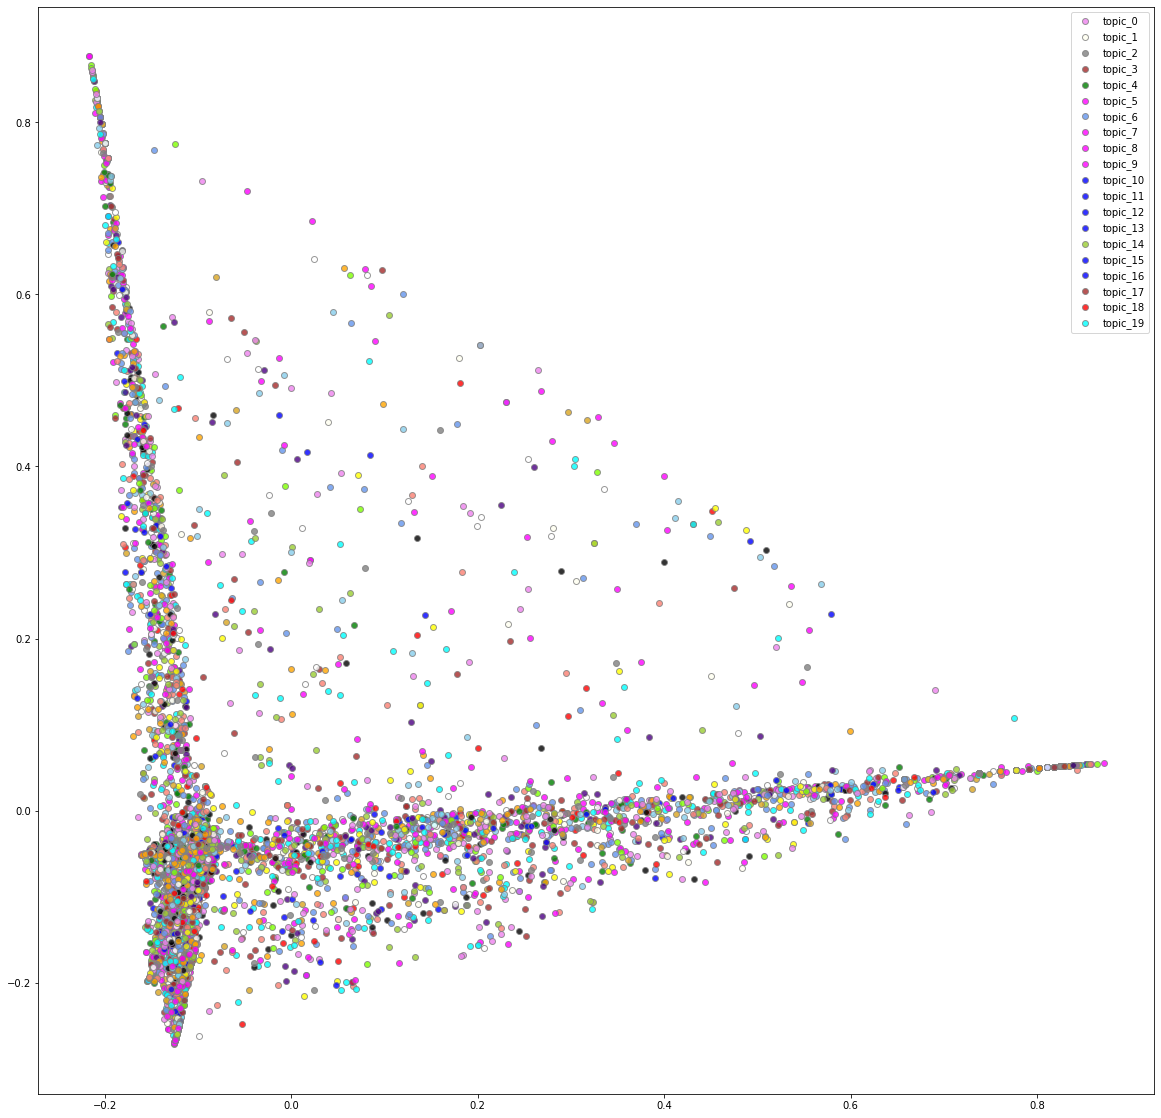

In [360]:
#It takes 11 hours to generate the scatter plot for the full population of good reviews
#just doing a random subset here

start_time = datetime.datetime.now()
plot_PCA_2D2(docReducedTopicMatrixGR_sub, docTopicMatrixGR_df)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

**TODO**
You ran the cluster on the whole set of bad reviews. Include that here and add some narration to it.